In [27]:
import glob
import os

from cdo import *
cdo = Cdo()

import xarray as xr
xr.set_options(keep_attrs=True)
import cf_xarray as cfxr
import rioxarray as rxr

import xcdat as xc
import xesmf as xe

from cartopy import crs as ccrs
import cartopy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import colormaps as cmo 

import numpy as np
import scipy as sc
import pandas as pd
import geopandas as gpd
import regionmask

from rich import print as rprint
from tqdm.notebook import tqdm
%load_ext rich

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


In [28]:
west = 106.3640
east = 107.1060
north = -5.1350
south = -6.1810

# west = 106.8463
# east = 106.9361
# south = -6.1160
# north = -6.0584

extent = [west, east, south, north]

In [29]:
chl_exported = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_sentinel3_concatenated.nc')
chl_exported = chl_exported.sel(lon=slice(west,east),lat=slice(south,north))

ref_exported = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/ref_sentinel3_concatenated.nc')
ref_exported = ref_exported.sel(lon=slice(west,east),lat=slice(south,north))

area = gpd.read_file("/mnt/d/Documents/Resources/Layers/BatasWilayah25K/Batas_Wilayah_Administrasi__Area_.shp")
area = area.to_crs(ccrs.PlateCarree().proj4_init)
area = gpd.clip(area, mask=(west,south,east,north), keep_geom_type=True)

In [30]:
chl_exported['chl_nn'] = np.log10(chl_exported['chl_nn'])
chl_exported['chl_oc'] = np.log10(chl_exported['chl_oc'])
chl_exported['tsm_nn'] = np.log10(chl_exported['tsm_nn'])

In [31]:
area_mask = regionmask.mask_geopandas(area, chl_exported.lon.values, chl_exported.lat.values)

mask1 = 1 * np.ones((chl_exported.dims['lat'], chl_exported.dims['lon'])) * np.isnan(area_mask)
mask2 = 0 * np.ones((chl_exported.dims['lat'], chl_exported.dims['lon'])) * np.isfinite(area_mask)
mask0 = mask1 + mask2

mask = mask0.to_dataset()
mask.lat.attrs = {
    'units' : 'degrees_north',
    'unit_long' : "Degrees North",
    'standard_name' : "latitude",
    'long_name' : "Latitude",
    'axis' : 'Y'
}

mask.lon.attrs = {
    'units' : 'degrees_east',
    'unit_long' : "Degrees East",
    'standard_name' : "longitude",
    'long_name' : "Longitude",
    'axis' : 'Y'
}


/tmp/ipykernel_13167/880650394.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  mask1 = 1 * np.ones((chl_exported.dims['lat'], chl_exported.dims['lon'])) * np.isnan(area_mask)
/tmp/ipykernel_13167/880650394.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  mask2 = 0 * np.ones((chl_exported.dims['lat'], chl_exported.dims['lon'])) * np.isfinite(area_mask)


In [32]:
if os.path.exists('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/mask_jakarta-bay.nc'):
    os.remove('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/mask_jakarta-bay.nc')
else:
    print("Will create new file.")

mask.to_netcdf(
    '/mnt/d/Documents/Programming/Python/Output/IMBER/Data/mask_jakarta-bay.nc', 
    format = 'NETCDF4', 
    encoding = {
        "mask" : {'dtype':'int32', 'zlib':'True', 'complevel':4,'_FillValue':-999.},
    }
) 

In [33]:
maskker = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/mask_jakarta-bay.nc')['mask']
masker = maskker.where(maskker == 0)

num_land = np.sum(maskker == 0)
num_oce = np.sum(maskker == 1)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/edskywalker/.miniconda/envs/eds/lib/python3.9/site-packages/xarray/backends/file_manager.p │
│ y:211 in _acquire_with_cache_info                                                                │
│                                                                                                  │
│   208 │   │   """Acquire a file, returning the file and whether it was cached."""                │
│   209 │   │   with self._optional_lock(needs_lock):                                              │
│   210 │   │   │   try:                                                                           │
│ ❱ 211 │   │   │   │   file = self._cache[self._key]                                              │
│   212 │   │   │   except KeyError:                                                               │
│   213 │   │   │   │   kwargs = self._kwargs                                                      │
│   214 │   │   │   │   if self._mode is not _DEFAULT_MODE:                                        │
│                                                                                                  │
│ /home/edskywalker/.miniconda/envs/eds/lib/python3.9/site-packages/xarray/backends/lru_cache.py:5 │
│ 6 in __getitem__                                                                                 │
│                                                                                                  │
│    53 │   def __getitem__(self, key: K) -> V:                                                    │
│    54 │   │   # record recent use of the key by moving it to the front of the list               │
│    55 │   │   with self._lock:                                                                   │
│ ❱  56 │   │   │   value = self._cache[key]                                                       │
│    57 │   │   │   self._cache.move_to_end(key)                                                   │
│    58 │   │   │   return value                                                                   │
│    59                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: [<class 'netCDF4._netCDF4.Dataset'>, ('/home/edskywalker/Python/Output/IMBER/Data/mask_jakarta-bay.nc',),
'r', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('persist', False)), 
'421ff181-2619-48f0-a3e5-a7ff67edf24b']

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 maskker = xr.open_dataset('/home/edskywalker/Python/Output/IMBER/Data/mask_jakarta-bay.n     │
│   2 masker = maskker.where(maskker == 0)                                                         │
│   3                                                                                              │
│   4 num_land = np.sum(maskker == 0)                                                              │
│                                                                                                  │
│ /home/edskywalker/.miniconda/envs/eds/lib/python3.9/site-packages/xarray/backends/api.py:573 in  │
│ open_dataset                                                                                     │
│                                                                                                  │
│    570 │   )                                                                                     │
│    571 │                                                                                         │
│    572 │   overwrite_encoded_chunks = kwargs.

In [34]:
comp = dict(zlib=True, complevel=4, _FillValue=-999.)

chl_dropna = xr.Dataset()

chl_dropna['chl_nn'] = chl_exported.chl_nn.dropna(dim='time', how='any', thresh=int(0.1*num_oce))
chl_dropna['chl_oc'] = chl_exported.chl_oc.dropna(dim='time', how='any', thresh=int(0.1*num_oce))
chl_dropna['tsm_nn'] = chl_exported.tsm_nn.dropna(dim='time', how='any', thresh=int(0.1*num_oce))


if os.path.exists('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_sentinel3_concat_dropna.nc'):
    os.remove('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_sentinel3_concat_dropna.nc')
else:
    print("Will create new file.")

chl_dropna.to_netcdf(
    '/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_sentinel3_concat_dropna.nc',
    format = 'NETCDF4',
    unlimited_dims = 'time',
    encoding = {var: comp for var in chl_dropna.data_vars}
    )

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│    2                                                                                             │
│    3 chl_dropna = xr.Dataset()                                                                   │
│    4                                                                                             │
│ ❱  5 chl_dropna['chl_nn'] = chl_exported.chl_nn.dropna(dim='time', how='any', thresh=int(0.1*    │
│    6 chl_dropna['chl_oc'] = chl_exported.chl_oc.dropna(dim='time', how='any', thresh=int(0.1*    │
│    7 chl_dropna['tsm_nn'] = chl_exported.tsm_nn.dropna(dim='time', how='any', thresh=int(0.1*    │
│    8                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'num_oce' is not defined

In [35]:
ref_dropna = xr.Dataset()

ref_dropna['Oa06'] = ref_exported.Oa06.dropna(dim='time', how='any', thresh=int(0.1*num_oce))
ref_dropna['Oa07'] = ref_exported.Oa07.dropna(dim='time', how='any', thresh=int(0.1*num_oce))
ref_dropna['Oa08'] = ref_exported.Oa08.dropna(dim='time', how='any', thresh=int(0.1*num_oce))
ref_dropna['Oa09'] = ref_exported.Oa09.dropna(dim='time', how='any', thresh=int(0.1*num_oce))
ref_dropna['Oa10'] = ref_exported.Oa10.dropna(dim='time', how='any', thresh=int(0.1*num_oce))
ref_dropna['Oa11'] = ref_exported.Oa11.dropna(dim='time', how='any', thresh=int(0.1*num_oce))
ref_dropna['Oa12'] = ref_exported.Oa12.dropna(dim='time', how='any', thresh=int(0.1*num_oce))

if os.path.exists('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/ref_sentinel3_concat_dropna.nc'):
    os.remove('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/ref_sentinel3_concat_dropna.nc')
else:
    print("Will create new file.")


ref_dropna.to_netcdf(
    '/mnt/d/Documents/Programming/Python/Output/IMBER/Data/ref_sentinel3_concat_dropna.nc',
    format = 'NETCDF4',
    unlimited_dims = 'time',
    encoding = {var: comp for var in ref_dropna.data_vars}
    )

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 ref_dropna = xr.Dataset()                                                                   │
│    2                                                                                             │
│ ❱  3 ref_dropna['Oa06'] = ref_exported.Oa06.dropna(dim='time', how='any', thresh=int(0.1*num_    │
│    4 ref_dropna['Oa07'] = ref_exported.Oa07.dropna(dim='time', how='any', thresh=int(0.1*num_    │
│    5 ref_dropna['Oa08'] = ref_exported.Oa08.dropna(dim='time', how='any', thresh=int(0.1*num_    │
│    6 ref_dropna['Oa09'] = ref_exported.Oa09.dropna(dim='time', how='any', thresh=int(0.1*num_    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'num_oce' is not defined

In [36]:
seasonal_chl = chl_dropna.groupby('time.season').mean()
seasonal_chl = seasonal_chl.reindex(season = ['DJF','MAM','JJA','SON'])

seasonal_ref = ref_dropna.groupby('time.season').mean()
seasonal_ref = seasonal_ref.reindex(season = ['DJF','MAM','JJA','SON'])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/edskywalker/.miniconda/envs/eds/lib/python3.9/site-packages/xarray/core/dataset.py", line 1446, in _construct_dataarray
    variable = self._variables[name]
KeyError: 'time.season'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/edskywalker/.miniconda/envs/eds/lib/python3.9/site-packages/xarray/core/dataset.py", line 1545, in __getitem__
    return self._construct_dataarray(key)
  File "/home/edskywalker/.miniconda/envs/eds/lib/python3.9/site-packages/xarray/core/dataset.py", line 1448, in _construct_dataarray
    _, name, variable = _get_virtual_variable(self._variables, name, self.sizes)
  File "/home/edskywalker/.miniconda/envs/eds/lib/python3.9/site-packages/xarray/core/dataset.py", line 210, in _get_virtual_variable
    ref_var = variables[ref_name]
KeyError: 'time'

The above exception was the direct cause of the following exception:

Traceback (most recent call

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│    2                                                                                             │
│    3 for i in range(4):                                                                          │
│    4 │   ax[i].set_extent(extent, crs=ccrs.PlateCarree())                                        │
│ ❱  5 │   masker.plot(ax=ax[i], transform = ccrs.PlateCarree(), cmap=cmo.GMT_gray, add_colorba    │
│    6 │                                                                                           │
│    7 │   ini = ax[i].gridlines(draw_labels = True, alpha=0.5)                                    │
│    8 │   ini.top_labels = False                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'masker' is not defined

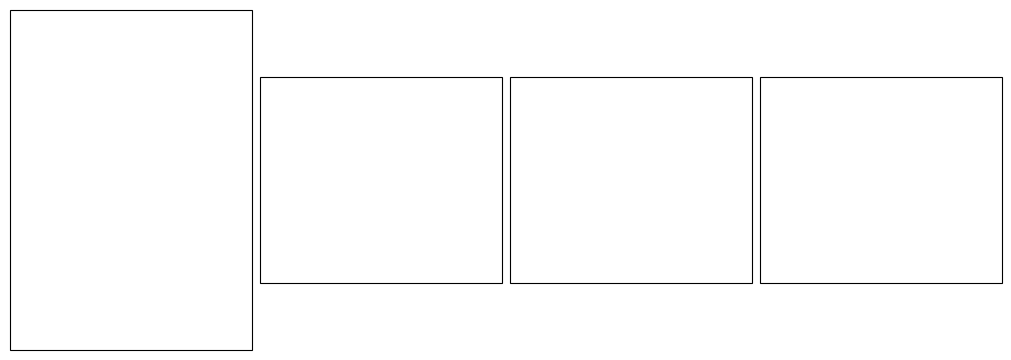

In [37]:
fig, ax = plt.subplots(figsize=[10,6], ncols=4, layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

for i in range(4):
    ax[i].set_extent(extent, crs=ccrs.PlateCarree())
    masker.plot(ax=ax[i], transform = ccrs.PlateCarree(), cmap=cmo.GMT_gray, add_colorbar=False, zorder=1)

    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False
    if not i == 0:
        ini.left_labels = False

seasonal_ref.Oa06.isel(season='DJF').plot(ax=ax[0], add_colorbar=False, norm=colors.Normalize(0.01,0.1), cmap=cmo.thermal, zorder=0, transform=ccrs.PlateCarree())
seasonal_ref.Oa07.isel(season='DJF').plot(ax=ax[0], add_colorbar=False, norm=colors.Normalize(0.01,0.1), cmap=cmo.thermal, zorder=0, transform=ccrs.PlateCarree())
seasonal_ref.Oa08.isel(season='DJF').plot(ax=ax[0], add_colorbar=False, norm=colors.Normalize(0.01,0.1), cmap=cmo.thermal, zorder=0, transform=ccrs.PlateCarree())
seasonal_ref.Oa12.isel(season='DJF').plot(ax=ax[0], add_colorbar=False, norm=colors.Normalize(0.01,0.1), cmap=cmo.thermal, zorder=0, transform=ccrs.PlateCarree())

cbar = plt.colorbar(cm.ScalarMappable(cmap=cmo.thermal, norm=colors.Normalize(0.01,0.1)), shrink=0.7, aspect=40, pad=0.02, orientation = 'horizontal', label = 'Reflectances',ax=ax[0:])